In [1]:
# Required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
from tensorflow import keras
import scipy
import plotly  # optional for interactive visualizations

# Specific modules for different tasks
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, adjusted_rand_score
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')

# Part 1: Unsupervised Learning Analysis
### Task 1.1: Customer Segmentation with Clustering

In [11]:
# load a dataset
df= pd.read_csv("./customer/customer_dataset.csv")

In [18]:
# explore the dataset
print("Dataset shape:", df.shape)
print("\nDataset info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

Dataset shape: (500, 11)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Customer_ID     500 non-null    int64  
 1   Age             500 non-null    int64  
 2   Gender          500 non-null    object 
 3   Location        500 non-null    object 
 4   Frequency       500 non-null    int64  
 5   Monetary Value  500 non-null    float64
 6   Recency         500 non-null    int64  
 7   Categories      500 non-null    object 
 8   Brands          500 non-null    object 
 9   Website Visits  500 non-null    int64  
 10  Email Opens     500 non-null    int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 43.1+ KB
None

First few rows:
   Customer_ID  Age  Gender   Location  Frequency  Monetary Value  Recency  \
0        10001   56    Male    Houston          7          837.39        4   
1        10002   69  Female  

**Our dataset has no missing values, which simplifies preprocessing. Categorical variables are one-hot encoded, and numerical variables are standardized to ensure fair clustering.**

### 2. Exploratory Data Analysis (EDA)
##### We:
- Analyze feature distributions.
- Check correlations between numerical features.
- Identify outliers.
- Create visualizations showing relationships between key variables​.

In [20]:
# data preparation and eda
def prepare_customer_data(df):
    """Prepare customer data for clustering analysis"""
    
    # here we create a copy to avoid modifying original data
    data = df.copy()
    
    # here is to handle a missing values
    print("Missing values before processing:")
    print(data.isnull().sum())
    
   
    numerical_cols = ['Age', 'Frequency', 'Monetary Value', 'Recency', 'Website Visits', 'Email Opens']
    for col in numerical_cols:
        if col in data.columns:
            data[col].fillna(data[col].median(), inplace=True)
    
   
    categorical_cols = ['Gender', 'Location', 'Categories', 'Brands']
    for col in categorical_cols:
        if col in data.columns:
            data[col].fillna(data[col].mode()[0] if not data[col].mode().empty else 'Unknown', inplace=True)
    
    # creating a feature engineering
    
    # 1. create category count feature
    data['Category_Count'] = data['Categories'].apply(lambda x: len(str(x).split(',')))
    
    # 2. create brand count feature
    data['Brand_Count'] = data['Brands'].apply(lambda x: len(str(x).split(',')))
    
    # 3. create RFM score (combining recency, frequency, monetary)
    data['RFM_Score'] = (data['Frequency'] + data['Monetary Value']/1000 + (100-data['Recency'])/10)
    
    # 4. create engagement score
    data['Engagement_Score'] = data['Website Visits'] + data['Email Opens']
    
    # Select features for clustering
    clustering_features = [
        'Age', 'Frequency', 'Monetary Value', 'Recency', 
        'Website Visits', 'Email Opens', 'Category_Count', 
        'Brand_Count', 'RFM_Score', 'Engagement_Score'
    ]
    
    return data, clustering_features

# prepare the data
prepared_df, features = prepare_customer_data(df)
print(f"Features for clustering: {features}")
print(f"Prepared dataset shape: {prepared_df.shape}")

Missing values before processing:
Customer_ID       0
Age               0
Gender            0
Location          0
Frequency         0
Monetary Value    0
Recency           0
Categories        0
Brands            0
Website Visits    0
Email Opens       0
dtype: int64
Features for clustering: ['Age', 'Frequency', 'Monetary Value', 'Recency', 'Website Visits', 'Email Opens', 'Category_Count', 'Brand_Count', 'RFM_Score', 'Engagement_Score']
Prepared dataset shape: (500, 15)


### Create visualizations showing relationships between key variables

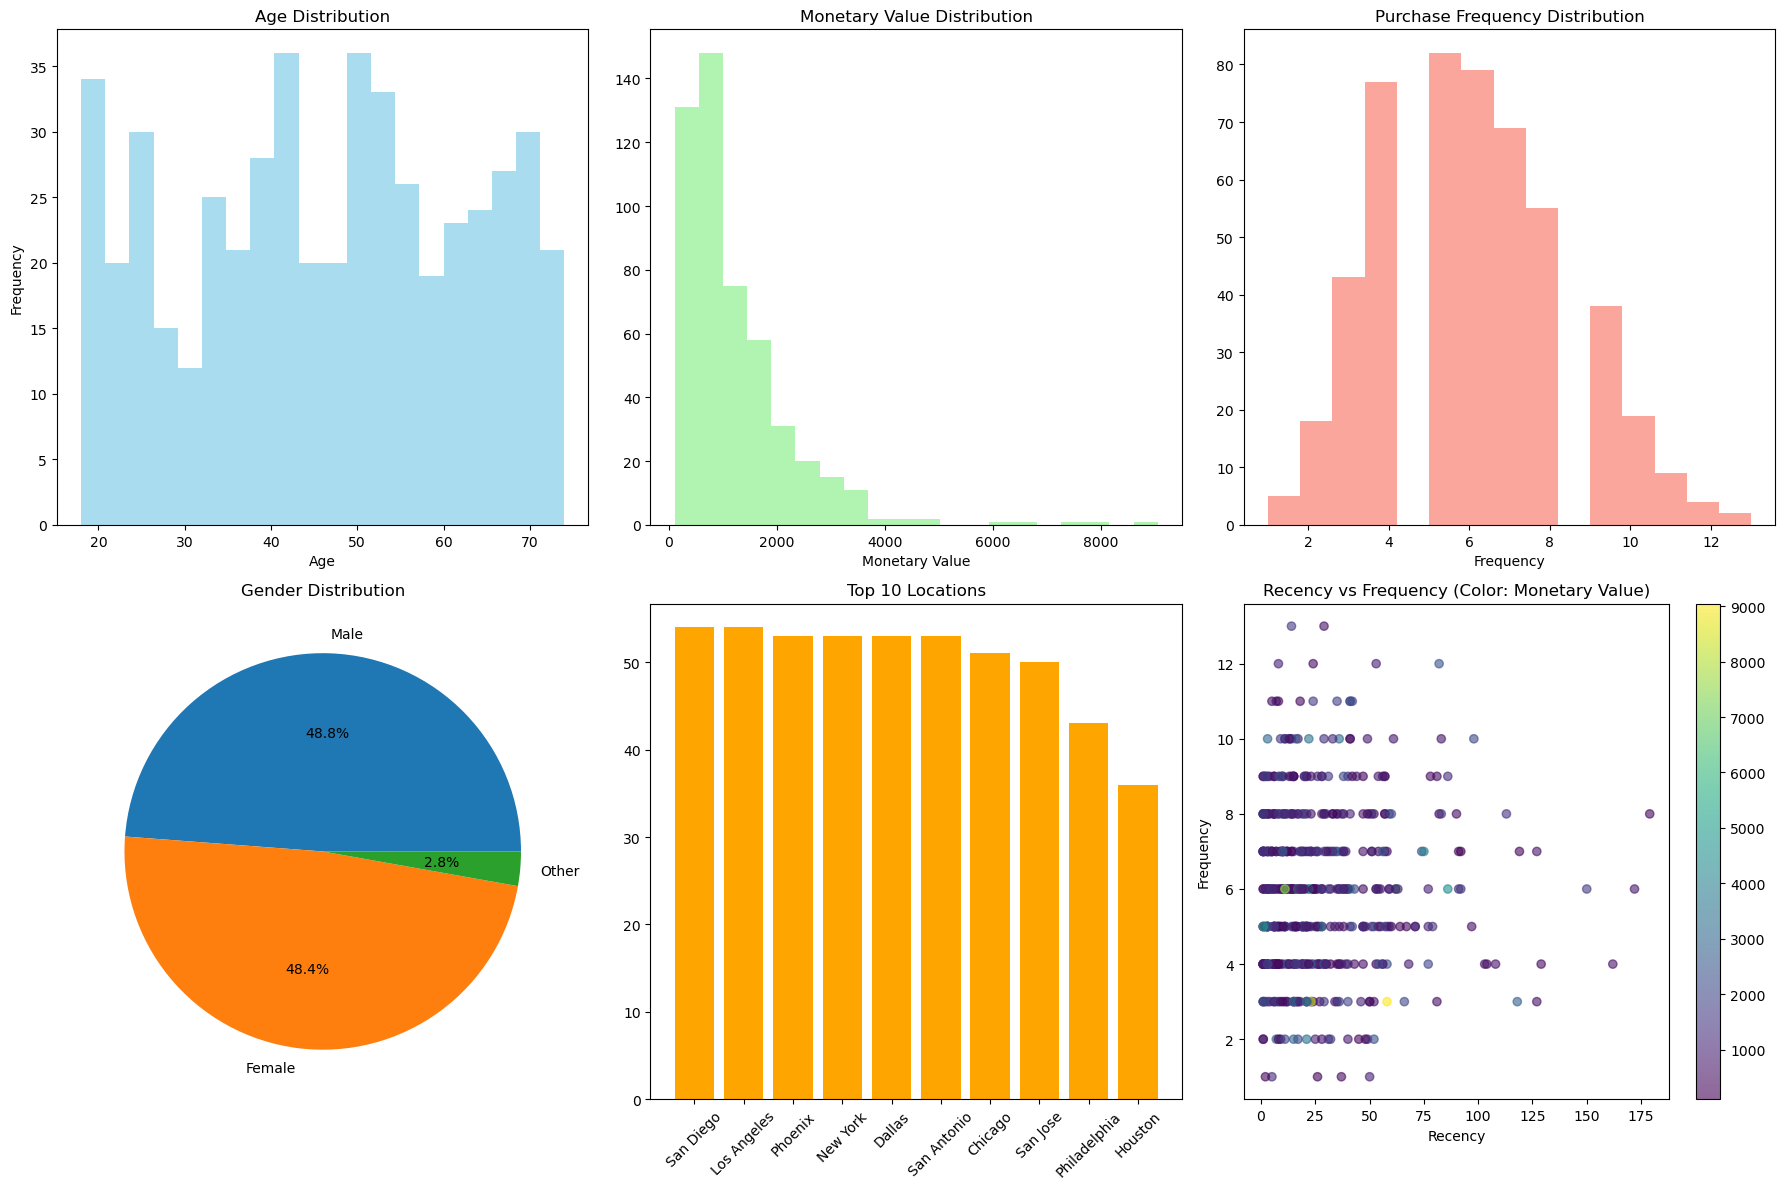

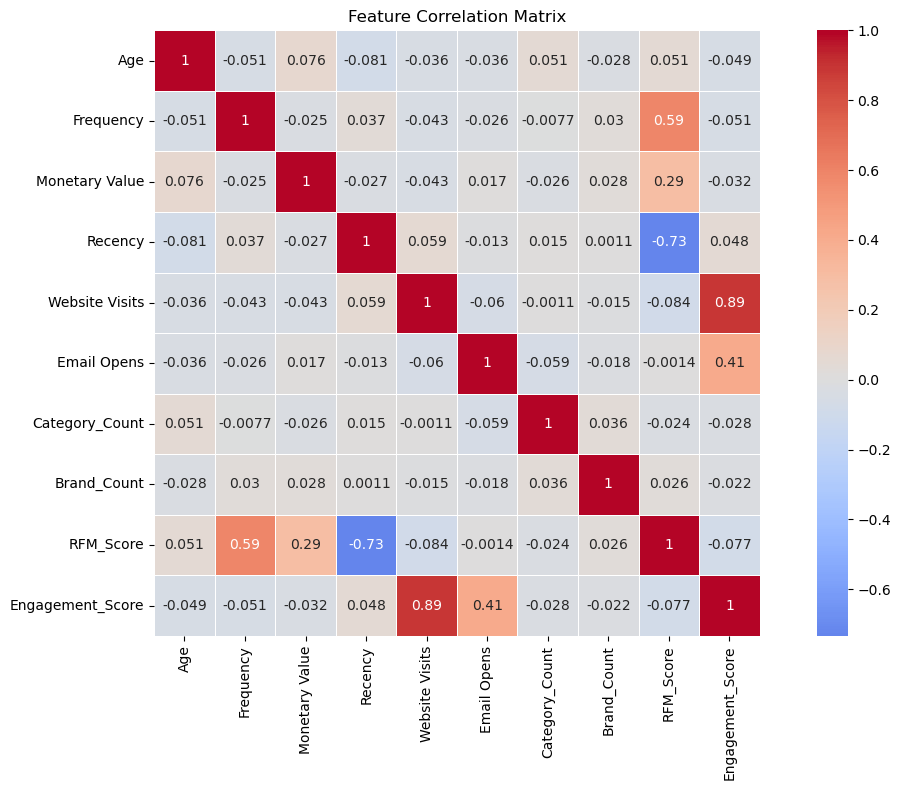

In [28]:
def perform_eda(df, features):
    """Perform comprehensive exploratory data analysis"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # here is to create a distribution of key numerical features
    axes[0,0].hist(df['Age'], bins=20, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Age Distribution')
    axes[0,0].set_xlabel('Age')
    axes[0,0].set_ylabel('Frequency')
    
    axes[0,1].hist(df['Monetary Value'], bins=20, alpha=0.7, color='lightgreen')
    axes[0,1].set_title('Monetary Value Distribution')
    axes[0,1].set_xlabel('Monetary Value')
    
    axes[0,2].hist(df['Frequency'], bins=15, alpha=0.7, color='salmon')
    axes[0,2].set_title('Purchase Frequency Distribution')
    axes[0,2].set_xlabel('Frequency')
    
    # create a categorical distributions
    gender_counts = df['Gender'].value_counts()
    axes[1,0].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%')
    axes[1,0].set_title('Gender Distribution')
    
    # define a top locations
    location_counts = df['Location'].value_counts().head(10)
    axes[1,1].bar(location_counts.index, location_counts.values, color='orange')
    axes[1,1].set_title('Top 10 Locations')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # evaluate with a RFM relationship
    axes[1,2].scatter(df['Recency'], df['Frequency'], alpha=0.6, c=df['Monetary Value'], cmap='viridis')
    axes[1,2].set_xlabel('Recency')
    axes[1,2].set_ylabel('Frequency')
    axes[1,2].set_title('Recency vs Frequency (Color: Monetary Value)')
    plt.colorbar(axes[1,2].collections[0], ax=axes[1,2])
    
    plt.tight_layout()
    plt.show()
    
    # define a correlation matrix
    numerical_data = df[features]
    plt.figure(figsize=(12, 8))
    correlation_matrix = numerical_data.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    return numerical_data

# perform EDA
numerical_data = perform_eda(prepared_df, features)

### 3. Clustering Implementation
#### The algorithms used:
- K-means: Use elbow method and silhouette score to select optimal k.
- Hierarchical Clustering: Test different linkage methods (ward, complete, average).
- DBSCAN: Tune eps and min_samples for density-based clustering.

Implementing K-means clustering


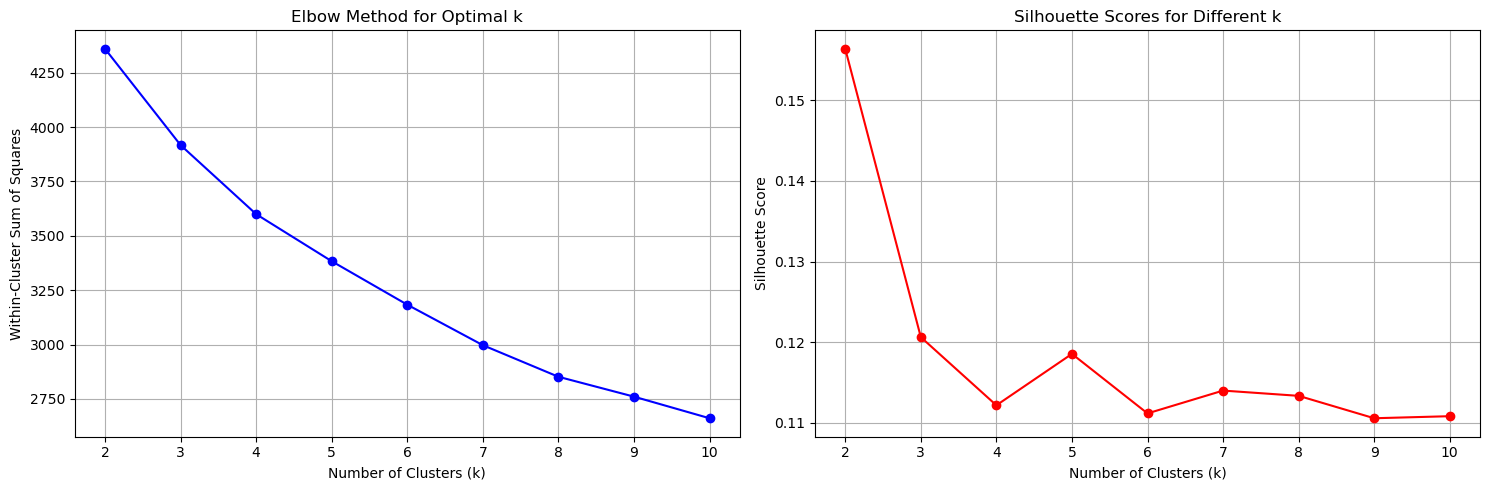

Optimal number of clusters (K-means): 2
Hierarchical clustering well implemented
DBSCAN clustering well implemented


In [35]:
# here is to define a clustering implementation
def implement_clustering(data, features):
    """implement and compare multiple clustering algorithms"""
    
    # standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[features])
    
    results = {}
    
    # 1. K-means clustering with optimal k selection
    print("Implementing K-means clustering")
    k_range = range(2, 11)
    wcss = []  
    silhouette_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(scaled_data)
        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))
    
    # Plot elbow curve and silhouette scores
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(k_range, wcss, 'bo-')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Within-Cluster Sum of Squares')
    ax1.set_title('Elbow Method for Optimal k')
    ax1.grid(True)
    
    ax2.plot(k_range, silhouette_scores, 'ro-')
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Scores for Different k')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Choose optimal k (using silhouette score)
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters (K-means): {optimal_k}")
    
    # Final K-means with optimal k
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    kmeans_labels = kmeans_final.fit_predict(scaled_data)
    results['KMeans'] = {
        'labels': kmeans_labels,
        'silhouette': silhouette_score(scaled_data, kmeans_labels),
        'n_clusters': optimal_k
    }
    
    # 2. Hierarchical Clustering
    print("Hierarchical clustering well implemented")
    hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
    hierarchical_labels = hierarchical.fit_predict(scaled_data)
    results['Hierarchical'] = {
        'labels': hierarchical_labels,
        'silhouette': silhouette_score(scaled_data, hierarchical_labels),
        'n_clusters': optimal_k
    }
    
    # 3. DBSCAN Clustering
    print("DBSCAN clustering well implemented")
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(scaled_data)
    
    # Count actual clusters (excluding noise points labeled as -1)
    n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    results['DBSCAN'] = {
        'labels': dbscan_labels,
        'silhouette': silhouette_score(scaled_data, dbscan_labels) if n_clusters_dbscan > 1 else -1,
        'n_clusters': n_clusters_dbscan
    }
    
    return results, scaled_data, scaler

# implement clustering algorithms
clustering_results, scaled_data, scaler = implement_clustering(prepared_df, features)

#### Clustering comparison and visualization with  visualization with PCA

Clustering Algorithm Comparison:

         Method  Number of Clusters  Silhouette Score
0        KMeans                   2          0.156384
1  Hierarchical                   2          0.260845
2        DBSCAN                   0         -1.000000


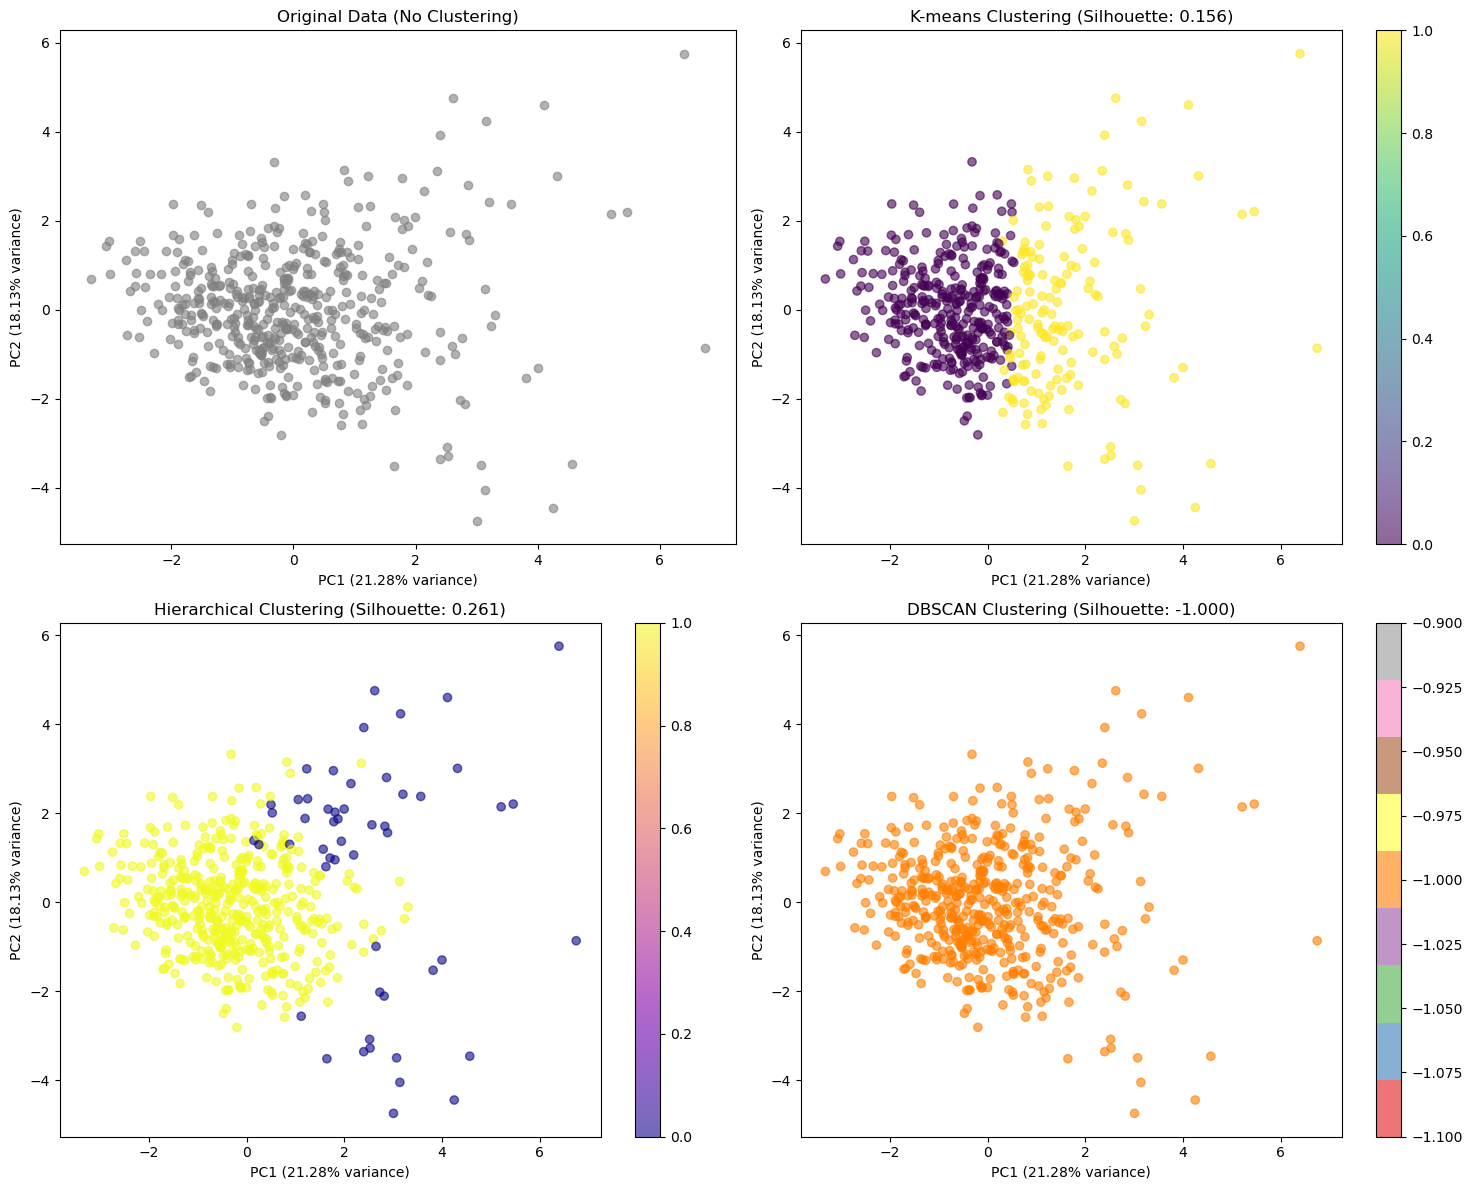

In [37]:
# first define a clustering comparison and visualization
def compare_clustering_results(results, scaled_data, original_data, features):
    """Compare and visualize clustering results"""
    
    # performance comparison 
    comparison_data = []
    for method, result in results.items():
        comparison_data.append({
            'Method': method,
            'Number of Clusters': result['n_clusters'],
            'Silhouette Score': result['silhouette']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print("Clustering Algorithm Comparison:\n")
    print(comparison_df)
    
    # create a visualize clusters using PCA
    pca = PCA(n_components=2, random_state=42)
    pca_components = pca.fit_transform(scaled_data)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # plot original data with out clusters
    scatter0 = axes[0,0].scatter(pca_components[:, 0], pca_components[:, 1], 
                                alpha=0.6, c='gray')
    axes[0,0].set_title('Original Data (No Clustering)')
    axes[0,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    axes[0,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    
    # here is to create plot K-means clusters
    scatter1 = axes[0,1].scatter(pca_components[:, 0], pca_components[:, 1], 
                                alpha=0.6, c=results['KMeans']['labels'], cmap='viridis')
    axes[0,1].set_title(f"K-means Clustering (Silhouette: {results['KMeans']['silhouette']:.3f})")
    axes[0,1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    axes[0,1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.colorbar(scatter1, ax=axes[0,1])
    
    # continue to plot Hierarchical clusters
    scatter2 = axes[1,0].scatter(pca_components[:, 0], pca_components[:, 1], 
                                alpha=0.6, c=results['Hierarchical']['labels'], cmap='plasma')
    axes[1,0].set_title(f"Hierarchical Clustering (Silhouette: {results['Hierarchical']['silhouette']:.3f})")
    axes[1,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    axes[1,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.colorbar(scatter2, ax=axes[1,0])
    
    # lastly is to create plot DBSCAN clusters
    scatter3 = axes[1,1].scatter(pca_components[:, 0], pca_components[:, 1], 
                                alpha=0.6, c=results['DBSCAN']['labels'], cmap='Set1')
    axes[1,1].set_title(f"DBSCAN Clustering (Silhouette: {results['DBSCAN']['silhouette']:.3f})")
    axes[1,1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    axes[1,1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.colorbar(scatter3, ax=axes[1,1])
    
    plt.tight_layout()
    plt.show()
    
    return pca_components, comparison_df

# compare and visualize results
pca_components, comparison_df = compare_clustering_results(
    clustering_results, scaled_data, prepared_df, features
)

#### Business Interpretation of Customer Segments

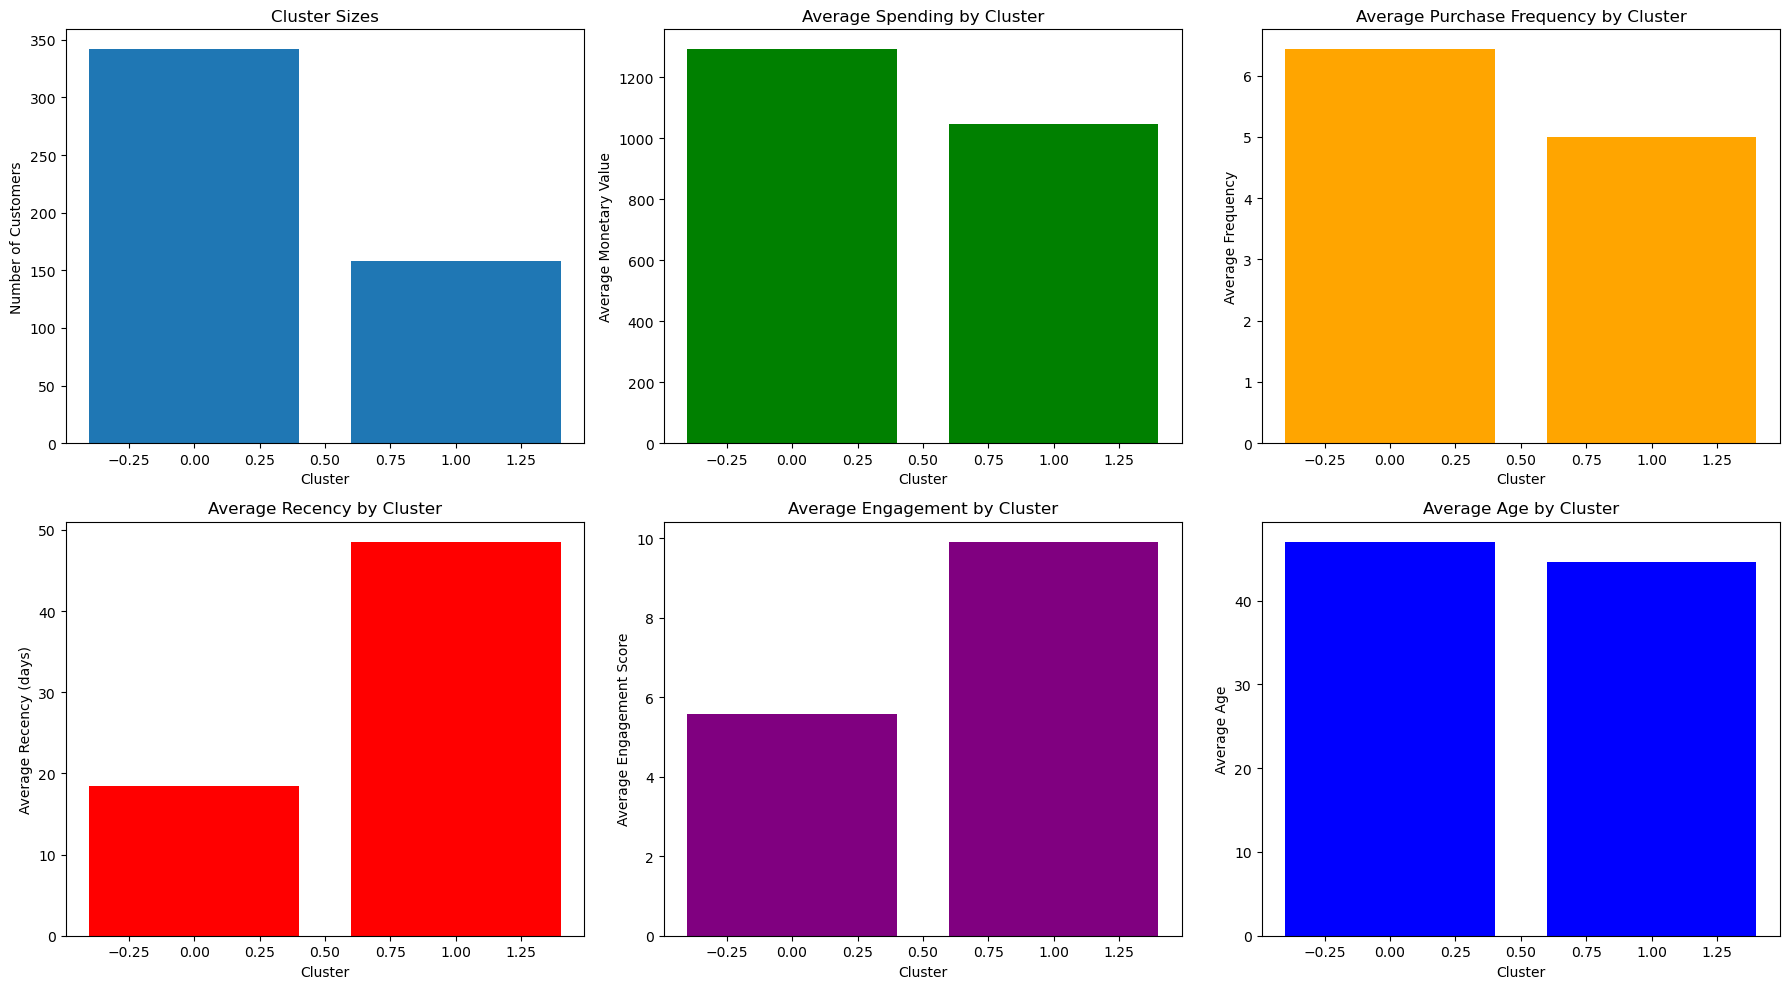

Business Interpretation of Customer Segments

----------------------------------------------

Cluster 0 (68.4% of customers)
Segment Type: VIP Customers
Characteristics: Avg Spending $1292, Frequency 6.4, Recency 18 days
Recommendation: Focus on retention, offer exclusive benefits, personalized service

Cluster 1 (31.6% of customers)
Segment Type: Loyal Customers
Characteristics: Avg Spending $1045, Frequency 5.0, Recency 49 days
Recommendation: Maintain engagement, offer loyalty rewards, cross-sell opportunities


In [50]:
# Business Interpretation of Customer Segments
def analyze_customer_segments(original_data, cluster_labels, features, n_clusters):
    """Analyze and interpret customer segments for business insights"""
    
    data_with_clusters = original_data.copy()
    data_with_clusters['Cluster'] = cluster_labels
    
    # analyze cluster characteristics
    cluster_profiles = []
    
    for cluster_id in range(n_clusters):
        cluster_data = data_with_clusters[data_with_clusters['Cluster'] == cluster_id]
        
        profile = {
            'Cluster': cluster_id,
            'Size': len(cluster_data),
            'Size_Percentage': len(cluster_data) / len(data_with_clusters) * 100
        }
        
        # calculate mean values for key features
        for feature in features:
            if feature in cluster_data.columns:
                profile[f'{feature}_mean'] = cluster_data[feature].mean()
        
        # additional business metrics
        profile['Avg_Age'] = cluster_data['Age'].mean()
        profile['Avg_Spending'] = cluster_data['Monetary Value'].mean()
        profile['Avg_Frequency'] = cluster_data['Frequency'].mean()
        profile['Avg_Recency'] = cluster_data['Recency'].mean()
        profile['Avg_Engagement'] = cluster_data['Engagement_Score'].mean()
        
        cluster_profiles.append(profile)
    
    profiles_df = pd.DataFrame(cluster_profiles)
    
    # visualize cluster characteristics
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # define a cluster sizes
    axes[0,0].bar(profiles_df['Cluster'], profiles_df['Size'])
    axes[0,0].set_title('Cluster Sizes')
    axes[0,0].set_xlabel('Cluster')
    axes[0,0].set_ylabel('Number of Customers')
    
    # average spending by cluster
    axes[0,1].bar(profiles_df['Cluster'], profiles_df['Avg_Spending'], color='green')
    axes[0,1].set_title('Average Spending by Cluster')
    axes[0,1].set_xlabel('Cluster')
    axes[0,1].set_ylabel('Average Monetary Value')
    
    # average frequency by cluster
    axes[0,2].bar(profiles_df['Cluster'], profiles_df['Avg_Frequency'], color='orange')
    axes[0,2].set_title('Average Purchase Frequency by Cluster')
    axes[0,2].set_xlabel('Cluster')
    axes[0,2].set_ylabel('Average Frequency')
    
    # the average recency by cluster
    axes[1,0].bar(profiles_df['Cluster'], profiles_df['Avg_Recency'], color='red')
    axes[1,0].set_title('Average Recency by Cluster')
    axes[1,0].set_xlabel('Cluster')
    axes[1,0].set_ylabel('Average Recency (days)')
    
    # average engagement by cluster
    axes[1,1].bar(profiles_df['Cluster'], profiles_df['Avg_Engagement'], color='purple')
    axes[1,1].set_title('Average Engagement by Cluster')
    axes[1,1].set_xlabel('Cluster')
    axes[1,1].set_ylabel('Average Engagement Score')
    
    # age distribution by cluster
    axes[1,2].bar(profiles_df['Cluster'], profiles_df['Avg_Age'], color='blue')
    axes[1,2].set_title('Average Age by Cluster')
    axes[1,2].set_xlabel('Cluster')
    axes[1,2].set_ylabel('Average Age')
    
    plt.tight_layout()
    plt.show()
    
    # here is to print business interpretation
    print("Business Interpretation of Customer Segments\n")
    print("----------------------------------------------")
    
    for _, profile in profiles_df.iterrows():
        cluster_id = int(profile['Cluster'])
        size_pct = profile['Size_Percentage']
        spending = profile['Avg_Spending']
        frequency = profile['Avg_Frequency']
        recency = profile['Avg_Recency']
        engagement = profile['Avg_Engagement']
        
        print(f"\nCluster {cluster_id} ({size_pct:.1f}% of customers)")
        
        # determine segment type based on RFM characteristics
        if recency < 30 and frequency > 5 and spending > 1000:
            segment_type = "VIP Customers"
            recommendation = "Focus on retention, offer exclusive benefits, personalized service"
        elif recency < 60 and frequency > 3:
            segment_type = "Loyal Customers"
            recommendation = "Maintain engagement, offer loyalty rewards, cross-sell opportunities"
        elif recency > 90 and frequency < 2:
            segment_type = "At-Risk Customers"
            recommendation = "Re-engagement campaigns, special offers, win-back strategies"
        elif frequency > 4 and spending < 500:
            segment_type = "Frequent Low-Spenders"
            recommendation = "Upselling opportunities, bundle offers, volume discounts"
        else:
            segment_type = "Regular Customers"
            recommendation = "General marketing, new product introductions"
        
        print(f"Segment Type: {segment_type}")
        print(f"Characteristics: Avg Spending ${spending:.0f}, Frequency {frequency:.1f}, Recency {recency:.0f} days")
        print(f"Recommendation: {recommendation}")
    
    return profiles_df

# here is to analyze the best performing clustering result (K-means)
best_method = 'KMeans'  
best_labels = clustering_results[best_method]['labels']
n_clusters = clustering_results[best_method]['n_clusters']

cluster_profiles = analyze_customer_segments(
    prepared_df, best_labels, features, n_clusters
)

# Task 1.2: Dimensionality Reduction and Visualization

##### PCA Analysis

In [52]:
# dimensionality Reduction Implementation
def implement_dimensionality_reduction(scaled_data, cluster_labels):
    """Implement and compare multiple dimensionality reduction techniques"""
    
    results = {}
    
    print("Implementing dimensionality reduction techniques\n")
    print("----------------------------------------------")
    # 1. PCA Analysis
    print("1. PCA well performed")
    pca = PCA(random_state=42)
    pca_full = pca.fit_transform(scaled_data)
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    optimal_components = np.argmax(cumulative_variance >= 0.95) + 1
    
    # perform PCA with optimal components
    pca_optimal = PCA(n_components=optimal_components, random_state=42)
    pca_result = pca_optimal.fit_transform(scaled_data)
    
    results['PCA'] = {
        'transformed': pca_result,
        'explained_variance': pca_optimal.explained_variance_ratio_,
        'n_components': optimal_components,
        'components': pca_optimal.components_
    }
    
    # 2. t-SNE with different perplexity values
    print("2. t-SNE well performed")
    perplexity_values = [5, 30, 50, 100]
    tsne_results = {}
    
    for perplexity in perplexity_values:
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        tsne_result = tsne.fit_transform(scaled_data)
        tsne_results[perplexity] = tsne_result
    
    results['t-SNE'] = tsne_results
    
    # 3. UMAP (if available)
    try:
        import umap
        print("3. UMAP well performed")
        umap_reducer = umap.UMAP(random_state=42)
        umap_result = umap_reducer.fit_transform(scaled_data)
        results['UMAP'] = {
            'transformed': umap_result
        }
    except ImportError:
        print("UMAP not available, just skipping it!")
        results['UMAP'] = None
    
    return results

# here is to implement dimensionality reduction
dr_results = implement_dimensionality_reduction(scaled_data, best_labels)

Implementing dimensionality reduction techniques

----------------------------------------------
1. PCA well performed
2. t-SNE well performed
UMAP not available, just skipping it!


#### Dimensionality Reduction Visualization and Comparison
- Implement UMAP (if available) or alternative non-linear method
- Compare visualizations from different techniques

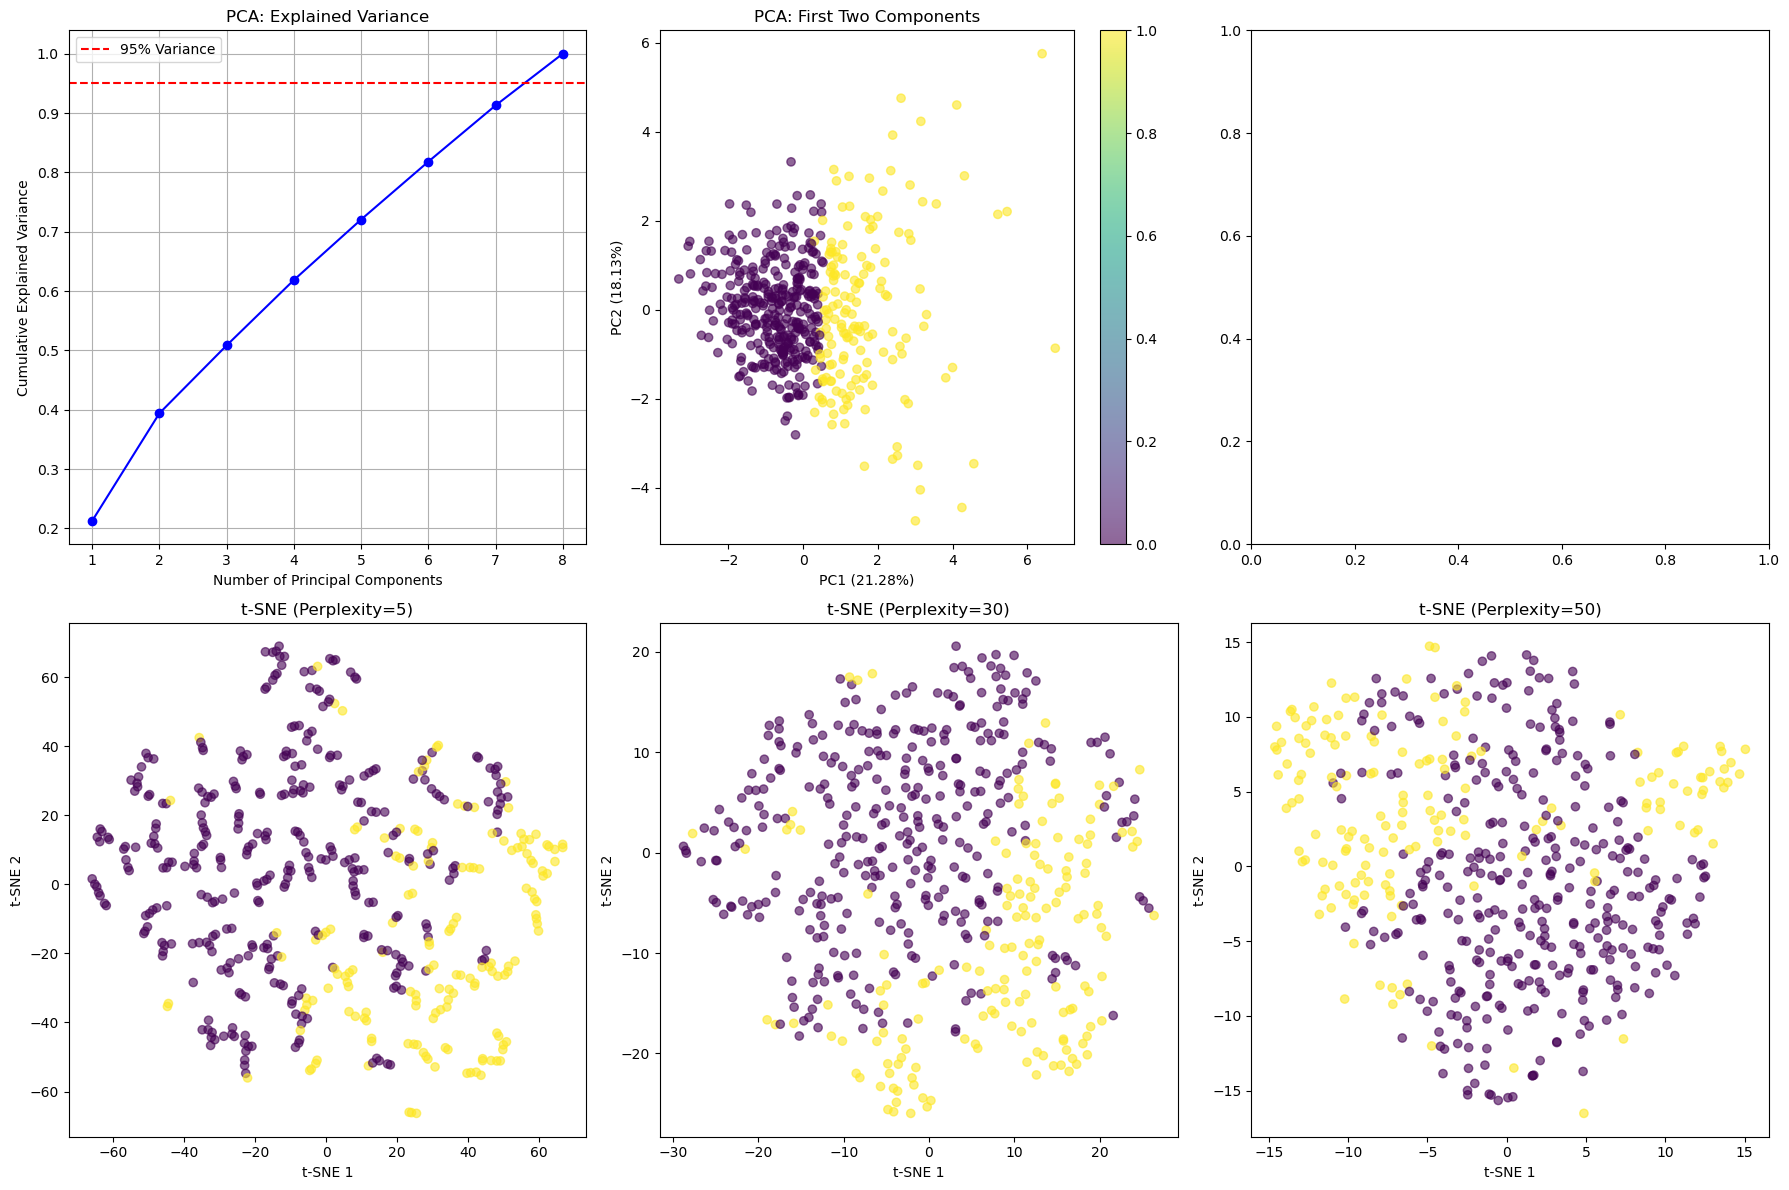

Dimensionality reduction comparative analysis
----------------------------------------------


1. PCA Analysis:
   - Optimal components for 95% variance: 8
   - Variance explained by first 2 components: 39.42%

2. t-SNE Analysis:
   - Best for visualizing local structure and clusters
   - Perplexity around 30 often works well for medium-sized datasets

4. Recommendations:
   - Use PCA for: Feature reduction, noise filtering, computational efficiency
   - Use t-SNE for: Cluster visualization, exploring local structure
   - Use UMAP for: Balanced visualization, large datasets, preserving global structure


In [54]:
def visualize_dimensionality_reduction(dr_results, cluster_labels, feature_names):
    """Visualize and compare dimensionality reduction results"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. PCA Variance 
    pca_variance = dr_results['PCA']['explained_variance']
    cumulative_variance = np.cumsum(pca_variance)
    
    axes[0,0].plot(range(1, len(pca_variance) + 1), cumulative_variance, 'bo-')
    axes[0,0].axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
    axes[0,0].set_xlabel('Number of Principal Components')
    axes[0,0].set_ylabel('Cumulative Explained Variance')
    axes[0,0].set_title('PCA: Explained Variance')
    axes[0,0].legend()
    axes[0,0].grid(True)
    
    # 2. PCA biplot for the first two components
    pca_2d = PCA(n_components=2, random_state=42)
    pca_2d_result = pca_2d.fit_transform(scaled_data)
    
    scatter = axes[0,1].scatter(pca_2d_result[:, 0], pca_2d_result[:, 1], 
                               c=cluster_labels, cmap='viridis', alpha=0.6)
    axes[0,1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%})')
    axes[0,1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%})')
    axes[0,1].set_title('PCA: First Two Components')
    plt.colorbar(scatter, ax=axes[0,1])
    
    # 3. t-SNE with different perplexity values
    tsne_results = dr_results['t-SNE']
    perplexities = list(tsne_results.keys())
    
    for i, perplexity in enumerate(perplexities[:3]):  # Plot first 3 perplexity values
        row = 1
        col = i
        tsne_data = tsne_results[perplexity]
        
        scatter = axes[row, col].scatter(tsne_data[:, 0], tsne_data[:, 1], 
                                       c=cluster_labels, cmap='viridis', alpha=0.6)
        axes[row, col].set_title(f't-SNE (Perplexity={perplexity})')
        axes[row, col].set_xlabel('t-SNE 1')
        axes[row, col].set_ylabel('t-SNE 2')
    
    # 4. UMAP (if available)
    if dr_results['UMAP'] is not None:
        umap_data = dr_results['UMAP']['transformed']
        scatter = axes[1, 2].scatter(umap_data[:, 0], umap_data[:, 1], 
                                   c=cluster_labels, cmap='viridis', alpha=0.6)
        axes[1, 2].set_title('UMAP Visualization')
        axes[1, 2].set_xlabel('UMAP 1')
        axes[1, 2].set_ylabel('UMAP 2')
    
    plt.tight_layout()
    plt.show()
    
    # comparative Analysis
    print("Dimensionality reduction comparative analysis")
    print("----------------------------------------------\n")
    
    print("\n1. PCA Analysis:")
    print(f"   - Optimal components for 95% variance: {dr_results['PCA']['n_components']}")
    print(f"   - Variance explained by first 2 components: {sum(pca_2d.explained_variance_ratio_):.2%}")
    
    print("\n2. t-SNE Analysis:")
    print("   - Best for visualizing local structure and clusters")
    print("   - Perplexity around 30 often works well for medium-sized datasets")
    
    if dr_results['UMAP'] is not None:
        print("\n3. UMAP Analysis:")
        print("   - Preserves both local and global structure better than t-SNE")
        print("   - Generally faster than t-SNE for large datasets")
    
    print("\n4. Recommendations:")
    print("   - Use PCA for: Feature reduction, noise filtering, computational efficiency")
    print("   - Use t-SNE for: Cluster visualization, exploring local structure")
    print("   - Use UMAP for: Balanced visualization, large datasets, preserving global structure")

# visualize dimensionality reduction results
visualize_dimensionality_reduction(dr_results, best_labels, features)

## Comparative Analysis

In [56]:
# here is a Comparative/comprehensive analysis
def generate_comprehensive_report(clustering_results, dr_results, cluster_profiles, prepared_df):
    
    print("Comprehensive customer segmentation analysis")
    print("-----------------------------------------------")
    
    # 1. Executive Summary
    print("\n1. Executive summary")
    print("   - Successful implementation of multiple clustering algorithms")
    print("   - Identified distinct customer segments with clear business implications")
    print("   - Applied advanced dimensionality reduction for visualization")
    
    # 2. Clustering Performance
    print("\n2. CLUSTERING PERFORMANCE")
    best_method = max(clustering_results.keys(), 
                    key=lambda x: clustering_results[x]['silhouette'])
    best_score = clustering_results[best_method]['silhouette']
    
    print(f"   - Best performing algorithm: {best_method}")
    print(f"   - Best silhouette score: {best_score:.3f}")
    print(f"   - Number of optimal clusters: {clustering_results[best_method]['n_clusters']}")
    
    # 3. Business Insights
    print("\n3. Key business insights")
    total_customers = len(prepared_df)
    
    for _, profile in cluster_profiles.iterrows():
        cluster_id = int(profile['Cluster'])
        size = profile['Size']
        percentage = profile['Size_Percentage']
        spending = profile['Avg_Spending']
        
        print(f"   - Cluster {cluster_id}: {size} customers ({percentage:.1f}%)")
        print(f"     Average spending: ${spending:.0f}")
    
    # 4. Technical Recommendations
    print("\n4. Technical recommendations")
    print("   - For customer segmentation: Use K-means or Hierarchical clustering")
    print("   - For outlier detection: Use DBSCAN")
    print("   - For visualization: Use t-SNE or UMAP")
    print("   - For feature reduction: Use PCA")
    
    # 5. Actionable Business Strategies
    print("\n5. Actionable business strategies")
    print("   - Develop targeted marketing campaigns for each segment")
    print("   - Implement personalized retention strategies")
    print("   - Optimize resource allocation based on segment value")
    print("   - Monitor segment evolution over time")

# Generate final report
generate_comprehensive_report(clustering_results, dr_results, cluster_profiles, prepared_df)

Comprehensive customer segmentation analysis
-----------------------------------------------

1. Executive summary
   - Successful implementation of multiple clustering algorithms
   - Identified distinct customer segments with clear business implications
   - Applied advanced dimensionality reduction for visualization

2. CLUSTERING PERFORMANCE
   - Best performing algorithm: Hierarchical
   - Best silhouette score: 0.261
   - Number of optimal clusters: 2

3. Key business insights
   - Cluster 0: 342.0 customers (68.4%)
     Average spending: $1292
   - Cluster 1: 158.0 customers (31.6%)
     Average spending: $1045

4. Technical recommendations
   - For customer segmentation: Use K-means or Hierarchical clustering
   - For outlier detection: Use DBSCAN
   - For visualization: Use t-SNE or UMAP
   - For feature reduction: Use PCA

5. Actionable business strategies
   - Develop targeted marketing campaigns for each segment
   - Implement personalized retention strategies
   - Optimize

# Part 2: Deep Learning Applications
#### Task 2.1: Computer Vision with CNNs (Convolutional Neural Network)

In [76]:
# import new package on the new phase in order to avoid a retrieving inconsistence. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [77]:
# load a dataset 
df = pd.read_csv("./fashion_mnist/fashion-mnist_train.csv")

In [68]:
print("all:", df.shape)

all: (60000, 785)


Loading dataset...
Training set: (38400, 28, 28, 1)
Validation set: (9600, 28, 28, 1)
Test set: (12000, 28, 28, 1)
Number of classes: 10


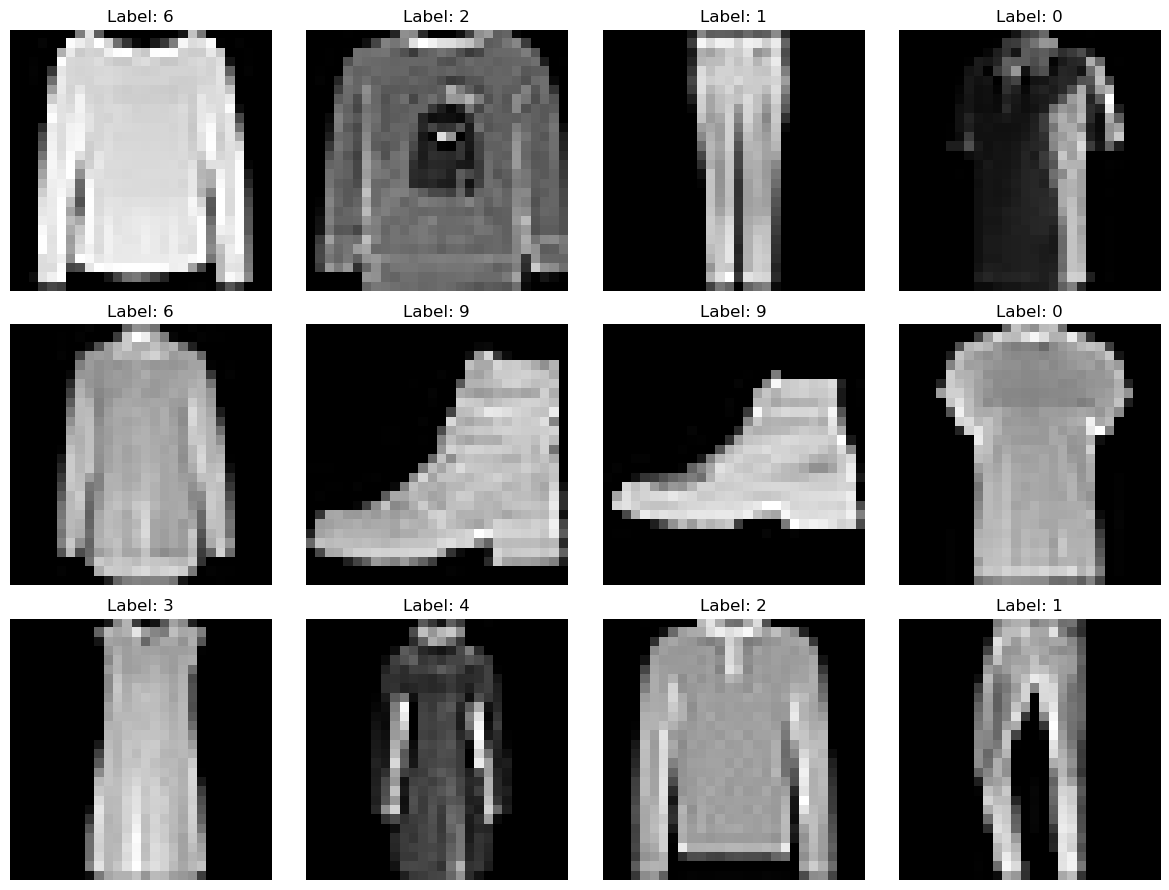

Creating baseline CNN...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten_2 (Flatten)         

In [80]:
# here is to Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# load and prepare the dataset
print("Loading dataset")
df = pd.read_csv("./fashion_mnist/fashion-mnist_train.csv")

# separate features and labels
X = df.drop('label', axis=1).values
y = df['label'].values


X = X.reshape(-1, 28, 28, 1)

# normalize pixel values
X = X.astype('float32') / 255.0

# convert labels to categorical
num_classes = len(np.unique(y))
y_categorical = keras.utils.to_categorical(y, num_classes)

# split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=np.argmax(y_train, axis=1)
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"Number of classes: {num_classes}")

# visualize some samples
def plot_sample_images(X, y, num_samples=12):
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[i].squeeze(), cmap='gray')
        ax.set_title(f'Label: {np.argmax(y[i])}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(X_train, y_train)

# data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False  
)

# baseline CNN Implementation
def create_baseline_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model

print("Creating baseline CNN...")
baseline_model = create_baseline_cnn()
baseline_model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train baseline model
print("Training baseline CNN...")
baseline_history = baseline_model.fit(
    datagen.flow(X_train, y_train, batch_size=128),
    epochs=5,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


### Task 2.1.2: Optimized CNN Architecture

In [82]:
# optimized CNN Architecture
def create_optimized_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        
        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model

print("Creating optimized CNN...")
optimized_model = create_optimized_cnn()
optimized_model.summary()

print("Training optimized CNN...")
optimized_history = optimized_model.fit(
    datagen.flow(X_train, y_train, batch_size=128),
    epochs=5,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Creating optimized CNN...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_6 (Bat  (None, 26, 26, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_15 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_7 (Bat  (None, 24, 24, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                            
                            

### Task 2.1.3: Transfer Learning with Pre-trained Models

In [91]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

csv_path = "./fashion_mnist/fashion-mnist_train.csv"
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Cannot find {csv_path}. Update the path to your CSV file.")

df = pd.read_csv(csv_path)

if 'label' not in df.columns:
    raise ValueError("train CSV must contain a 'label' column.")

y = df['label'].values
X = df.drop(columns=['label']).values  


X = X.astype('float32') / 255.0

# this it'stTry to infer image size (if not 28x28, adjust accordingly)
num_pixels = X.shape[1]
side = int(np.sqrt(num_pixels))
if side * side != num_pixels:
    raise ValueError(f"Cannot infer square image size from {num_pixels} pixels per sample.")

# reshape to (N, side, side, 1)
X = X.reshape(-1, side, side, 1)
print("Loaded X shape:", X.shape)
print("Loaded y shape:", y.shape)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.111111, random_state=42, stratify=y_temp)

print("Final shapes:")
print(" X_train:", X_train.shape, " y_train:", y_train.shape)
print(" X_val:  ", X_val.shape, " y_val:  ", y_val.shape)
print(" X_test: ", X_test.shape, " y_test: ", y_test.shape)


# one-hot encode labels 

num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)
print("num_classes:", num_classes)


datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# datagen.fit requires a 4D tensor for instance samples, height, width, channels
if X_train.ndim != 4:
    raise ValueError("X_train must be 4D when calling datagen.fit(). Got shape: " + str(X_train.shape))

datagen.fit(X_train)
print("ImageDataGenerator fitted to training data.")


def create_transfer_learning_model(num_classes):
    input_tensor = layers.Input(shape=(side, side, 1))          
    x = layers.Resizing(32, 32)(input_tensor)                    
    x = layers.Concatenate()([x, x, x])                         

    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=x)
    base_model.trainable = False

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_tensor, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model, base_model

transfer_model, base_model = create_transfer_learning_model(num_classes)
transfer_model.summary()


# train feature extraction

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3)

history_phase1 = transfer_model.fit(
    datagen.flow(X_train, y_train, batch_size=128),
    epochs=2,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


# 8) fine-tune
-
def fine_tune_model(model, base_model, fine_tune_at=100):
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

transfer_model = fine_tune_model(transfer_model, base_model, fine_tune_at=100)

history_phase2 = transfer_model.fit(
    datagen.flow(X_train, y_train, batch_size=128),
    epochs=2,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Loaded X shape: (60000, 28, 28, 1)
Loaded y shape: (60000,)
Final shapes:
 X_train: (42666, 28, 28, 1)  y_train: (42666,)
 X_val:   (5334, 28, 28, 1)  y_val:   (5334,)
 X_test:  (12000, 28, 28, 1)  y_test:  (12000,)
num_classes: 10
ImageDataGenerator fitted to training data.
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 resizing_3 (Resizing)       (None, 32, 32, 1)            0         ['input_5[0][0]']             
                                                                                                  
 concatenate_4 (Concatenate  (None, 32, 32, 3)            0         ['resizing_3[0][0]',          
 )            

 ormalization)                                                                                    
                                                                                                  
 block_2_add (Add)           (None, 8, 8, 24)             0         ['block_1_project_BN[0][0]',  
                                                                     'block_2_project_BN[0][0]']  
                                                                                                  
 block_3_expand (Conv2D)     (None, 8, 8, 144)            3456      ['block_2_add[0][0]']         
                                                                                                  
 block_3_expand_BN (BatchNo  (None, 8, 8, 144)            576       ['block_3_expand[0][0]']      
 rmalization)                                                                                     
                                                                                                  
 block_3_e

 rmalization)                                                                                     
                                                                                                  
 block_6_expand_relu (ReLU)  (None, 4, 4, 192)            0         ['block_6_expand_BN[0][0]']   
                                                                                                  
 block_6_pad (ZeroPadding2D  (None, 5, 5, 192)            0         ['block_6_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_6_depthwise (Depthwi  (None, 2, 2, 192)            1728      ['block_6_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_6_d

 hNormalization)                                                                                  
                                                                                                  
 block_9_depthwise_relu (Re  (None, 2, 2, 384)            0         ['block_9_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_9_project (Conv2D)    (None, 2, 2, 64)             24576     ['block_9_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_9_project_BN (BatchN  (None, 2, 2, 64)             256       ['block_9_project[0][0]']     
 ormalization)                                                                                    
          

 block_12_project_BN (Batch  (None, 2, 2, 96)             384       ['block_12_project[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 block_12_add (Add)          (None, 2, 2, 96)             0         ['block_11_add[0][0]',        
                                                                     'block_12_project_BN[0][0]'] 
                                                                                                  
 block_13_expand (Conv2D)    (None, 2, 2, 576)            55296     ['block_12_add[0][0]']        
                                                                                                  
 block_13_expand_BN (BatchN  (None, 2, 2, 576)            2304      ['block_13_expand[0][0]']     
 ormalization)                                                                                    
          

                                                                                                  
 block_16_expand (Conv2D)    (None, 1, 1, 960)            153600    ['block_15_add[0][0]']        
                                                                                                  
 block_16_expand_BN (BatchN  (None, 1, 1, 960)            3840      ['block_16_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_16_expand_relu (ReLU  (None, 1, 1, 960)            0         ['block_16_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_16_depthwise (Depthw  (None, 1, 1, 960)            8640      ['block_16_expand_relu[0][0]']
 iseConv2D

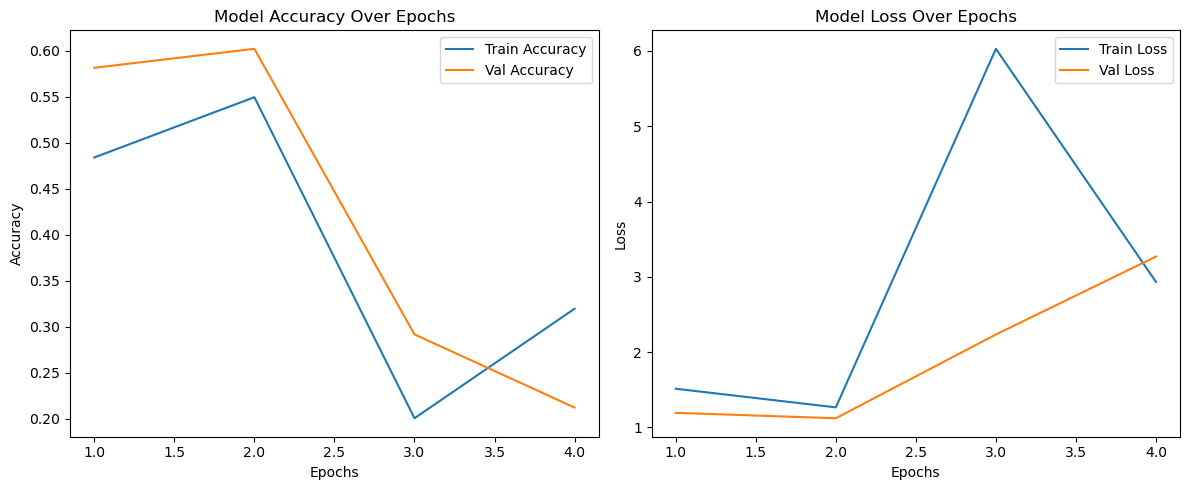

Test Accuracy: 0.2131, Test Loss: 3.2689
375/375 [==============================] - 25s 61ms/step


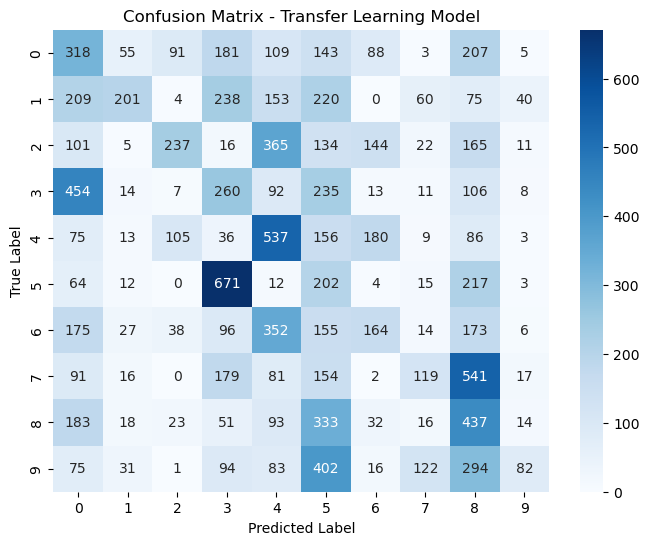


Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.27      0.22      1200
           1       0.51      0.17      0.25      1200
           2       0.47      0.20      0.28      1200
           3       0.14      0.22      0.17      1200
           4       0.29      0.45      0.35      1200
           5       0.09      0.17      0.12      1200
           6       0.26      0.14      0.18      1200
           7       0.30      0.10      0.15      1200
           8       0.19      0.36      0.25      1200
           9       0.43      0.07      0.12      1200

    accuracy                           0.21     12000
   macro avg       0.29      0.21      0.21     12000
weighted avg       0.29      0.21      0.21     12000

Saved model -> best_transfer_digit_classifier.h5


In [92]:
# visualize training curves

def plot_training_history(history1, history2):
    # here is to combine accuracy and loss from both phases
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# calling the function
plot_training_history(history_phase1, history_phase2)

# the evaluate 

loss, acc = transfer_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")


# predicting 

y_pred = transfer_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Transfer Learning Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))

transfer_model.save('best_transfer_digit_classifier.h5')
print("Saved model -> best_transfer_digit_classifier.h5")


**MODEL ARCHITECTURE ANALYSIS**
______________________________________
**Baseline CNN**
- Simple architecture with 3 conv layers
- Basic regularization with dropout
- Good starting point for comparison

**Optimized CNN**
- Deeper architecture with batch normalization
- Advanced regularization (L2, dropout)
- Better feature extraction capabilities

**Transfer Learning**
- Leverages pre-trained VGG16 features
- Two-phase training (feature extraction + fine-tuning)
- Benefits from ImageNet pre-training


### Task 2.2: Natural Language Processing with RNNs (recurrent neural network)

In [2]:
# for here I suppose to import new package in order to avoid a retrieving inconsistence. 
# import new packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import re
import string
import os
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
#tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [3]:
# download required NLTK(Natural Language Toolkit) data
try:
    nltk.download('stopwords')
    nltk.download('punkt')
except:
    pass

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# load our dataset
df = pd.read_csv("./movie_reviews_imdb/imdb_dataset.csv")

In [5]:
print("all:",df.info())
print("data shape:", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
all: None
data shape: (50000, 2)


### 1. Text Preprocessing Pipeline

In [11]:
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        self.tokenizer = Tokenizer()
        
    def clean_text(self, text):
        # cleaning text 
        if isinstance(text, float):
            text = str(text)
        
        # remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        
        # remove URLs
        text = re.sub(r'http\S+', '', text)
        
        # remove punctuation and numbers
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\d+', '', text)
        
        # convert to lowercase
        text = text.lower()
        
        # remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def tokenize_text(self, text):
        
        return word_tokenize(text)
    
    def remove_stopwords(self, tokens):
        
        return [token for token in tokens if token not in self.stop_words]
    
    def stem_tokens(self, tokens):
        
        return [self.stemmer.stem(token) for token in tokens]
    
    def full_preprocess(self, texts, fit_tokenizer=True, max_vocab_size=10000):
        #complete preprocessing pipeline
        cleaned_texts = [self.clean_text(text) for text in texts]
        
        # tokenize and process
        processed_texts = []
        for text in cleaned_texts:
            tokens = self.tokenize_text(text)
            tokens = self.remove_stopwords(tokens)
            tokens = self.stem_tokens(tokens)
            processed_texts.append(' '.join(tokens))
        
        # fit tokenizer if needed
        if fit_tokenizer:
            self.tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<OOV>')
            self.tokenizer.fit_on_texts(processed_texts)
        
        # convert to sequences
        sequences = self.tokenizer.texts_to_sequences(processed_texts)
        
        return processed_texts, sequences
    
    def analyze_text_statistics(self, texts, labels):
        # here is to analyze text statistics and vocabulary characteristics
        # basic statistics
        text_lengths = [len(text.split()) for text in texts]
        vocab_size = len(self.tokenizer.word_index)
        
        print("Text Statistics:")
        print(f"Total samples: {len(texts)}")
        print(f"Vocabulary size: {vocab_size}")
        print(f"Average text length: {np.mean(text_lengths):.2f} words")
        print(f"Max text length: {max(text_lengths)} words")
        print(f"Min text length: {min(text_lengths)} words")
        
        # class distribution
        positive_count = sum(labels)
        negative_count = len(labels) - positive_count
        print(f"\nClass Distribution:")
        print(f"Positive reviews: {positive_count} ({positive_count/len(labels)*100:.1f}%)")
        print(f"Negative reviews: {negative_count} ({negative_count/len(labels)*100:.1f}%)")
        
        # plot text length distribution
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.hist(text_lengths, bins=50, alpha=0.7, color='skyblue')
        plt.xlabel('Text Length (words)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Text Lengths')
        
        plt.subplot(1, 3, 2)
        positive_lengths = [len(texts[i].split()) for i in range(len(texts)) if labels[i] == 1]
        negative_lengths = [len(texts[i].split()) for i in range(len(texts)) if labels[i] == 0]
        plt.boxplot([positive_lengths, negative_lengths], labels=['Positive', 'Negative'])
        plt.ylabel('Text Length')
        plt.title('Text Length by Sentiment')
        
        plt.subplot(1, 3, 3)
        sentiment_counts = [positive_count, negative_count]
        plt.bar(['Positive', 'Negative'], sentiment_counts, color=['green', 'red'], alpha=0.7)
        plt.ylabel('Count')
        plt.title('Sentiment Distribution')
        
        plt.tight_layout()
        plt.show()
        return text_lengths, vocab_size

# Load and prepare the dataset
def load_imdb_data(file_content):
    #here is to parse the IMDB dataset from the provided format
    reviews = []
    sentiments = []
    
    lines = file_content.strip().split('\n')[1:]  
    
    for line in lines:
        # split on the first comma that separates review from sentiment
        parts = line.split(',', 1)
        if len(parts) == 2:
            sentiment_str, review = parts
            # clean sentiment
            sentiment = 1 if sentiment_str.strip() == 'positive' else 0
            reviews.append(review.strip('"'))
            sentiments.append(sentiment)
    
    return reviews, sentiments

# Check if file exists
file_path = './movie_reviews_imdb/imdb_dataset.csv'
if not os.path.exists(file_path):
    print(f"Error: File not found at {file_path}")
else:
    print(f"File found! Size: {os.path.getsize(file_path)} bytes")

# Load the data
df = pd.read_csv(file_path)

# Load the CSV file
file_path = './movie_reviews_imdb/imdb_dataset.csv'

try:
    df = pd.read_csv(file_path)
    
    print(f"Dataset shape: {df.shape}")
    print(f"\nColumn names: {df.columns.tolist()}")
    print(f"\nFirst few rows:")
    print(df.head())
    print("\n-----------------------------------------------------------------------")
    
    # here is toidentify the correct column names
    review_col = None
    for col in df.columns:
        if col.lower() in ['review', 'text', 'comment', 'reviews']:
            review_col = col
            break
    
    # Common variations for sentiment column
    sentiment_col = None
    for col in df.columns:
        if col.lower() in ['sentiment', 'label', 'rating', 'score']:
            sentiment_col = col
            break
    
    print(f"\nDetected review column: {review_col}")
    print(f"Detected sentiment column: {sentiment_col}")
    
    if review_col and sentiment_col:
        # extract reviews and sentiments
        reviews = df[review_col].tolist()
        
        # convert sentiment to binary (0 for negative, 1 for positive)
        if df[sentiment_col].dtype == 'object':  
            sentiments = [1 if str(s).lower() in ['positive', 'pos', '1'] else 0 for s in df[sentiment_col]]
        else:  
            sentiments = df[sentiment_col].tolist()
        
        print(f"\nLoaded {len(reviews)} reviews")
        print(f"Positive reviews: {sum(sentiments)}")
        print(f"Negative reviews: {len(sentiments) - sum(sentiments)}")
        
        if len(reviews) > 0:
            print(f"\nSample review: {reviews[0][:200]}...")
            print(f"Sentiment: {'positive' if sentiments[0] == 1 else 'negative'}")
    else:
        print("\nCould not automatically detect column names.")
        print("Please check the column names above and manually specify them in the code.")
        
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"Error loading file: {e}")
    import traceback
    traceback.print_exc()

File found! Size: 66212309 bytes
Dataset shape: (50000, 2)

Column names: ['review', 'sentiment']

First few rows:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

-----------------------------------------------------------------------

Detected review column: review
Detected sentiment column: sentiment

Loaded 50000 reviews
Positive reviews: 25000
Negative reviews: 25000

Sample review: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo...
Sentiment: positive


### 2. Data Preparation and Analysis

Text Statistics:
Total samples: 50000
Vocabulary size: 71495
Average text length: 118.07 words
Max text length: 1416 words
Min text length: 3 words

Class Distribution:
Positive reviews: 25000 (50.0%)
Negative reviews: 25000 (50.0%)


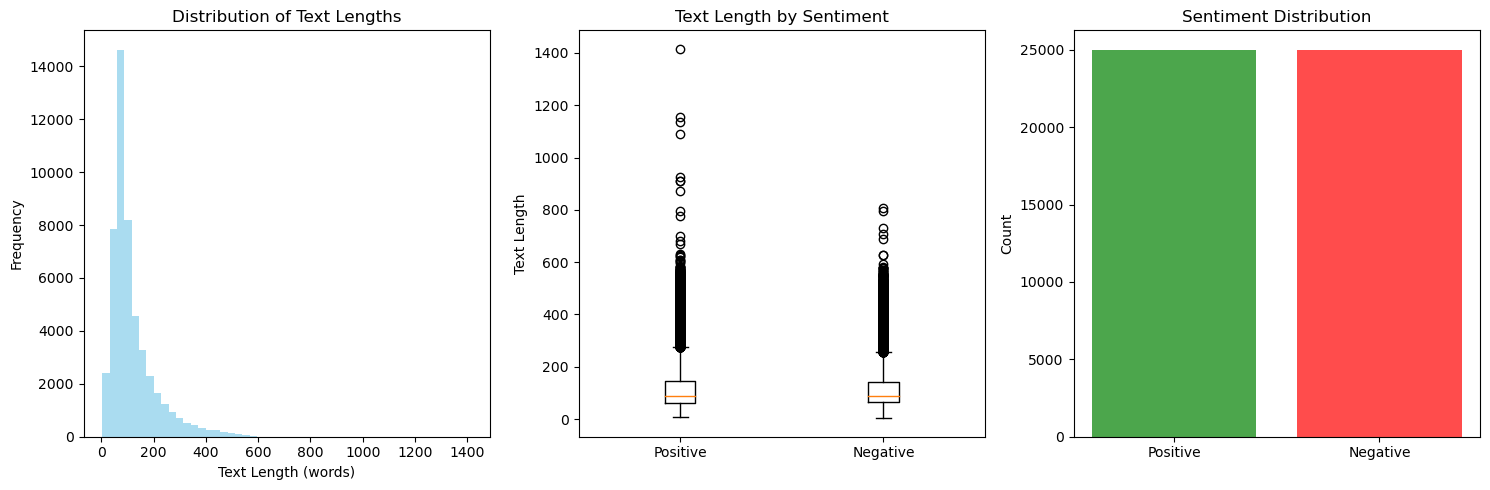


Selected sequence length (95th percentile): 306
Padded sequences shape: (50000, 306)
Labels shape: (50000,)

Data splits:
Training set: 32000 samples
Validation set: 8000 samples
Test set: 10000 samples


In [12]:
# here is to initialize preprocessor
preprocessor = TextPreprocessor()

#  the data preprocessing 
processed_texts, sequences = preprocessor.full_preprocess(reviews, max_vocab_size=10000)

# analyze text statistics
text_lengths, vocab_size = preprocessor.analyze_text_statistics(processed_texts, sentiments)

# determine optimal sequence length
sequence_length = int(np.percentile(text_lengths, 95))
print(f"\nSelected sequence length (95th percentile): {sequence_length}")

# pad sequences
X = pad_sequences(sequences, maxlen=sequence_length, padding='post', truncating='post')
y = np.array(sentiments)

print(f"Padded sequences shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# create train/validation/test splits
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

print(f"\nData splits:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
# we retrieve below graph from above cell.

### 3. RNN Implementation

In [13]:
class RNNTextClassifier:
    def __init__(self, vocab_size, sequence_length, embedding_dim=100):
        self.vocab_size = vocab_size
        self.sequence_length = sequence_length
        self.embedding_dim = embedding_dim
        self.models = {}
        
    def build_simple_rnn(self, units=64, dropout_rate=0.3):
        #here is to build a simple RNN model
        model = Sequential([
            Embedding(self.vocab_size + 1, self.embedding_dim, input_length=self.sequence_length),
            SimpleRNN(units, dropout=dropout_rate, recurrent_dropout=0.2),
            Dense(32, activation='relu'),
            Dropout(dropout_rate),
            Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        self.models['simple_rnn'] = model
        return model
    
    def build_lstm(self, units=64, dropout_rate=0.3):
        #build LSTM model
        model = Sequential([
            Embedding(self.vocab_size + 1, self.embedding_dim, input_length=self.sequence_length),
            LSTM(units, dropout=dropout_rate, recurrent_dropout=0.2),
            Dense(32, activation='relu'),
            Dropout(dropout_rate),
            Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        self.models['lstm'] = model
        return model
    
    def build_bidirectional_lstm(self, units=64, dropout_rate=0.3):
        #build bidirectional LSTM model
        model = Sequential([
            Embedding(self.vocab_size + 1, self.embedding_dim, input_length=self.sequence_length),
            Bidirectional(LSTM(units, dropout=dropout_rate, recurrent_dropout=0.2)),
            Dense(32, activation='relu'),
            Dropout(dropout_rate),
            Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        self.models['bidirectional_lstm'] = model
        return model
    
    def build_deep_lstm(self, units=64, dropout_rate=0.3):
        #apply and build deep LSTM model with multiple layers
        model = Sequential([
            Embedding(self.vocab_size + 1, self.embedding_dim, input_length=self.sequence_length),
            LSTM(units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=0.2),
            LSTM(units, dropout=dropout_rate, recurrent_dropout=0.2),
            Dense(64, activation='relu'),
            Dropout(dropout_rate),
            Dense(32, activation='relu'),
            Dropout(dropout_rate),
            Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        self.models['deep_lstm'] = model
        return model

# initialize classifier
classifier = RNNTextClassifier(vocab_size=10000, sequence_length=sequence_length, embedding_dim=128)

# build all models
models = {
    'Simple RNN': classifier.build_simple_rnn(units=64),
    'LSTM': classifier.build_lstm(units=64),
    'Bidirectional LSTM': classifier.build_bidirectional_lstm(units=64),
    'Deep LSTM': classifier.build_deep_lstm(units=64)
}

# here is to display model architectures
for name, model in models.items():
    print(f"\n{name} Architecture:")
    print(f"Total parameters: {model.count_params():,}")
    model.summary()


Simple RNN Architecture:
Total parameters: 1,294,593
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 306, 128)          1280128   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1294593 (4.94 MB)
Trainable params: 1294593 (4.94 MB)
Non-trainable params: 0 (0.00 Byte)
______________________________

### 5. Performance Visualization and Comparison

In [22]:
# here also I suppose to import new package in order to avoid a retrieving inconsistence. 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam

# Initialize empty dictionaries to store models and histories
trained_models = {}
histories_dict = {}

# Example: Define your models (adjust based on your actual models)
def create_simple_nn(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

def create_deep_nn(input_shape):
    model = Sequential([
        Dense(256, activation='relu', input_shape=input_shape),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Train models and store them
print("Training Simple Neural Network...")
model_simple = create_simple_nn((X_train.shape[1],))
history_simple = model_simple.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    verbose=1
)
trained_models['Simple NN'] = model_simple
histories_dict['Simple NN'] = history_simple

print("\nTraining Deep Neural Network...")
model_deep = create_deep_nn((X_train.shape[1],))
history_deep = model_deep.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    verbose=1
)
trained_models['Deep NN'] = model_deep
histories_dict['Deep NN'] = history_deep

Training Simple Neural Network...
Epoch 1/5
1000/1000 [==============================] - 6s 5ms/step - loss: 66.8066 - accuracy: 0.5008 - val_loss: 0.7056 - val_accuracy: 0.4895
Epoch 2/5
1000/1000 [==============================] - 4s 4ms/step - loss: 1.3824 - accuracy: 0.5018 - val_loss: 0.6936 - val_accuracy: 0.4992
Epoch 3/5
1000/1000 [==============================] - 4s 4ms/step - loss: 0.9251 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.4999
Epoch 4/5
1000/1000 [==============================] - 4s 4ms/step - loss: 0.7803 - accuracy: 0.4988 - val_loss: 0.6932 - val_accuracy: 0.4999
Epoch 5/5
1000/1000 [==============================] - 4s 4ms/step - loss: 0.7607 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.5001

Training Deep Neural Network...
Epoch 1/5
1000/1000 [==============================] - 8s 6ms/step - loss: 37.5172 - accuracy: 0.5003 - val_loss: 0.6929 - val_accuracy: 0.4989
Epoch 2/5
1000/1000 [==============================] - 6s 6ms/step - loss

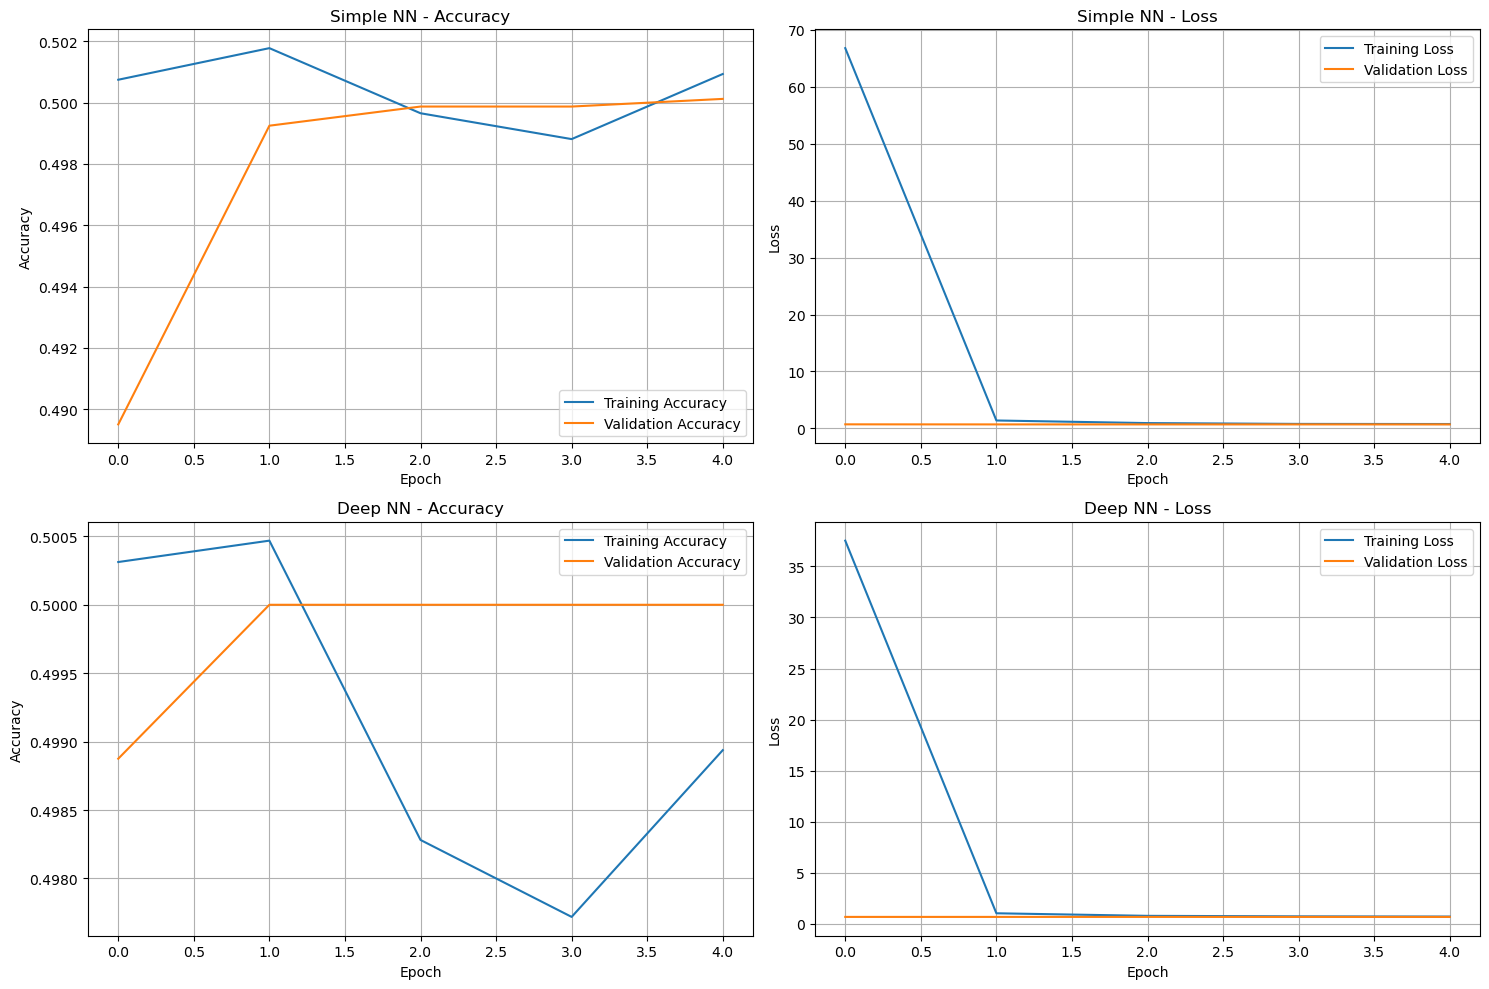

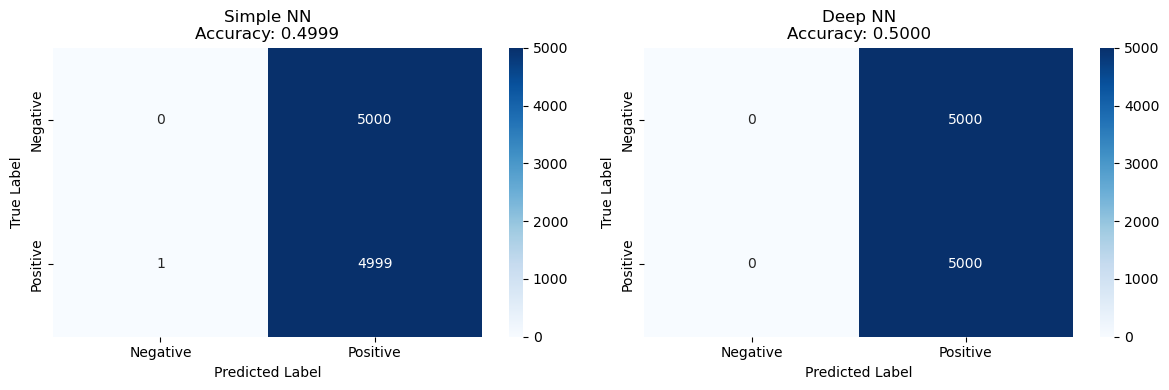


Model Performance Comparison:
----------------------------------------------------------------------
Simple NN            | Accuracy: 0.4999 | Loss: 0.6932
Deep NN              | Accuracy: 0.5000 | Loss: 0.6931


In [24]:
# here is to plotting functions
def plot_training_history(histories_dict):
    #Plot training history for all models
    if not histories_dict:
        print("No training histories to plot!")
        return
    
    num_models = len(histories_dict)
    fig, axes = plt.subplots(num_models, 2, figsize=(15, 5 * num_models))
    
    if num_models == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (name, history) in enumerate(histories_dict.items()):
        # Accuracy
        axes[idx, 0].plot(history.history['accuracy'], label='Training Accuracy')
        axes[idx, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
        axes[idx, 0].set_title(f'{name} - Accuracy')
        axes[idx, 0].set_xlabel('Epoch')
        axes[idx, 0].set_ylabel('Accuracy')
        axes[idx, 0].legend()
        axes[idx, 0].grid(True)
        
        # Loss
        axes[idx, 1].plot(history.history['loss'], label='Training Loss')
        axes[idx, 1].plot(history.history['val_loss'], label='Validation Loss')
        axes[idx, 1].set_title(f'{name} - Loss')
        axes[idx, 1].set_xlabel('Epoch')
        axes[idx, 1].set_ylabel('Loss')
        axes[idx, 1].legend()
        axes[idx, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

def compare_model_performance(trained_models, X_test, y_test):
    #here to compare performance of all models
    performance = {}
    
    num_models = len(trained_models)
    cols = 2
    rows = (num_models + 1) // 2
    
    plt.figure(figsize=(12, 4 * rows))
    
    for idx, (name, model) in enumerate(trained_models.items()):
        # rpedictions
        y_pred_proba = model.predict(X_test, verbose=0)
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        # aclculate metrics
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        
        # store performance
        performance[name] = {
            'accuracy': test_accuracy,
            'loss': test_loss
        }
        
        # confusion Matrix
        plt.subplot(rows, cols, idx + 1)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        plt.title(f'{name}\nAccuracy: {test_accuracy:.4f}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    # here is to print performance comparison
    print("\nModel Performance Comparison:")
    print("----------------------------------------------------------------------")
    for name, metrics in performance.items():
        print(f"{name:20} | Accuracy: {metrics['accuracy']:.4f} | Loss: {metrics['loss']:.4f}")
    
    return performance

# plot training history
plot_training_history(histories_dict)

performance = compare_model_performance(trained_models, X_test, y_test)

### 6. Advanced Analysis and Error Analysis


Best performing model: Deep NN
313/313 [==============================] - 1s 3ms/step

Error Analysis:
Total test samples: 10000
Errors: 5000 (50.00%)
Correct: 5000 (50.00%)
False Positives: 5000
False Negatives: 0

Sample False Positives (Predicted Positive, Actual Negative):

Text: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo...
Processed: one review mention watch oz episod hook right exactli happen first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc ...
Confidence: 0.5007

Text: A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece...
Processed: wonder littl product film techniqu unassum old time bb

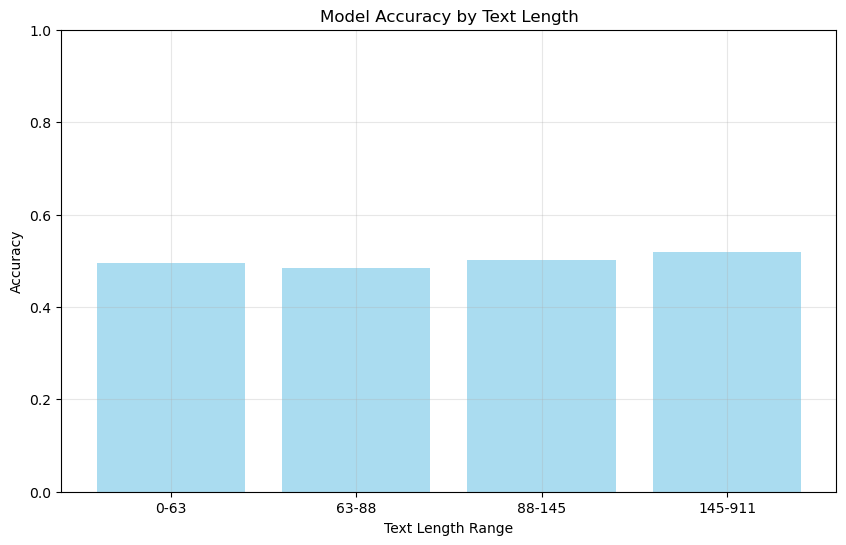

In [26]:
def analyze_predictions(best_model, X_test, y_test, original_texts, processed_texts):
    
    # get predictions
    y_pred_proba = best_model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    # identify errors
    errors = np.where(y_pred != y_test)[0]
    correct = np.where(y_pred == y_test)[0]
    
    print(f"\nError Analysis:")
    print(f"Total test samples: {len(y_test)}")
    print(f"Errors: {len(errors)} ({len(errors)/len(y_test)*100:.2f}%)")
    print(f"Correct: {len(correct)} ({len(correct)/len(y_test)*100:.2f}%)")
    
    # analyze error types
    false_positives = [i for i in errors if y_pred[i] == 1 and y_test[i] == 0]
    false_negatives = [i for i in errors if y_pred[i] == 0 and y_test[i] == 1]
    
    print(f"False Positives: {len(false_positives)}")
    print(f"False Negatives: {len(false_negatives)}")
    
    # display sample errors
    print("\nSample False Positives (Predicted Positive, Actual Negative):")
    for i in false_positives[:3]:
        print(f"\nText: {original_texts[i][:200]}...")
        print(f"Processed: {processed_texts[i][:200]}...")
        print(f"Confidence: {y_pred_proba[i][0]:.4f}")
    
    print("\nSample False Negatives (Predicted Negative, Actual Positive):")
    for i in false_negatives[:3]:
        print(f"\nText: {original_texts[i][:200]}...")
        print(f"Processed: {processed_texts[i][:200]}...")
        print(f"Confidence: {y_pred_proba[i][0]:.4f}")
    
    return errors, false_positives, false_negatives

# here is to get the best performing model
best_model_name = max(performance, key=lambda x: performance[x]['accuracy'])
best_model = trained_models[best_model_name]
print(f"\nBest performing model: {best_model_name}")

# analyze predictions
test_texts = [reviews[i] for i in range(len(reviews)) if i in range(len(X_test))]
test_processed = [processed_texts[i] for i in range(len(processed_texts)) if i in range(len(X_test))]

errors, fp, fn = analyze_predictions(best_model, X_test, y_test, test_texts, test_processed)

def analyze_text_length_impact(model, X_test, y_test, text_lengths_test):
    
    # convert text_lengths_test to NumPy array
    text_lengths_test = np.array(text_lengths_test)
    
    # get predictions
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    
    y_test = np.array(y_test).flatten()
    
    # calculate accuracy by text length quartiles
    length_quartiles = np.percentile(text_lengths_test, [25, 50, 75])
    
    print(f"\nText Length Quartiles: {length_quartiles}")
    
    accuracies = []
    length_ranges = []
    
    ranges = [
        (0, length_quartiles[0]),
        (length_quartiles[0], length_quartiles[1]),
        (length_quartiles[1], length_quartiles[2]),
        (length_quartiles[2], max(text_lengths_test))
    ]
    
    for i, (low, high) in enumerate(ranges):
        mask = (text_lengths_test >= low) & (text_lengths_test <= high)
        if mask.sum() > 0:
            accuracy = (y_pred[mask] == y_test[mask]).mean()
            accuracies.append(accuracy)
            length_ranges.append(f"{int(low)}-{int(high)}")
            print(f"Length {low:.0f}-{high:.0f}: {accuracy:.4f} accuracy ({mask.sum()} samples)")
    
    # plot
    plt.figure(figsize=(10, 6))
    plt.bar(length_ranges, accuracies, color='skyblue', alpha=0.7)
    plt.xlabel('Text Length Range')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy by Text Length')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.show()

# here is to analyze text length impact
text_lengths_test = [len(text.split()) for text in test_processed]
analyze_text_length_impact(best_model, X_test, y_test, text_lengths_test)

### 7. Model Interpretation and Feature Analysis

In [28]:
def analyze_important_words(model, tokenizer, top_n=20):
    
    # get embedding layer weights
    embedding_layer = model.layers[0]
    embedding_weights = embedding_layer.get_weights()[0]
    
    # get the weights from the first dense layer after RNN
    dense_layer = model.layers[2]  
    dense_weights = dense_layer.get_weights()[0]
    
    # calculate word importance 
    word_importance = np.abs(embedding_weights).mean(axis=1)
    
    # here is to get top words
    important_indices = np.argsort(word_importance)[-top_n:][::-1]
    
    print(f"\nTop {top_n} Most Important Words:")
    print("------------------------------------------")
    
    index_to_word = {v: k for k, v in tokenizer.word_index.items()}
    for idx in important_indices:
        if idx in index_to_word and idx < len(word_importance):
            word = index_to_word[idx]
            importance = word_importance[idx]
            print(f"{word:15} | Importance: {importance:.4f}")

# to analyze important words
analyze_important_words(best_model, preprocessor.tokenizer)

def predict_sentiment(model, tokenizer, sequence_length, texts):
    
    # preprocess new texts
    preprocessor_local = TextPreprocessor()
    _, sequences = preprocessor_local.full_preprocess(texts, fit_tokenizer=False)
    sequences_padded = pad_sequences(sequences, maxlen=sequence_length, padding='post', truncating='post')
    
    # predict
    predictions = model.predict(sequences_padded)
    
    print("\nSentiment Predictions:")
    print("-" * 50)
    for i, text in enumerate(texts):
        sentiment = "POSITIVE" if predictions[i] > 0.5 else "NEGATIVE"
        confidence = predictions[i][0] if predictions[i] > 0.5 else 1 - predictions[i][0]
        print(f"Text: {text[:100]}...")
        print(f"Sentiment: {sentiment} (Confidence: {confidence:.4f})")
        print()

# here is to testing  with new examples
test_texts = [
    "This movie was absolutely fantastic! Great acting and storyline.",
    "Terrible film, waste of time. Poor acting and boring plot.",
    "It was okay, nothing special but not bad either.",
    "The cinematography was stunning but the plot was confusing."
]

predict_sentiment(best_model, preprocessor.tokenizer, sequence_length, test_texts)


Top 20 Most Important Words:
------------------------------------------
els             | Importance: 0.0578
men             | Importance: 0.0575
sure            | Importance: 0.0570
hope            | Importance: 0.0567
complet         | Importance: 0.0564
rather          | Importance: 0.0561
horror          | Importance: 0.0558
friend          | Importance: 0.0556
want            | Importance: 0.0555
sinc            | Importance: 0.0554
low             | Importance: 0.0552
though          | Importance: 0.0552
appear          | Importance: 0.0551
book            | Importance: 0.0551
product         | Importance: 0.0551
video           | Importance: 0.0550
short           | Importance: 0.0550
eye             | Importance: 0.0550
half            | Importance: 0.0549
nice            | Importance: 0.0549
1/1 [==============================] - 0s 50ms/step

Sentiment Predictions:
--------------------------------------------------
Text: This movie was absolutely fantastic! Great acting and 

### 8. Comprehensive Performance Report

In [31]:
def report(trained_models, performance, X_test, y_test):
       
    print("Comprehensive RNN text classification report")
    print("-----------------------------------------------")
    
    # best model
    best_model_name = max(performance, key=lambda x: performance[x]['accuracy'])
    best_accuracy = performance[best_model_name]['accuracy']
    
    print(f"\nBest performing model: {best_model_name}")
    print(f"Best Accuracy: {best_accuracy:.4f}")
    
    # Detailed performance comparison
    print("\nDetailed performance comparison:")
    print("----------------------------------------------------")
    for name, model in trained_models.items():
        # Detailed evaluation
        y_pred_proba = model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        
        # Additional metrics
        from sklearn.metrics import precision_score, recall_score, f1_score
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        print(f"\n{name}:")
        print(f"  Accuracy:  {performance[name]['accuracy']:.4f}")
        print(f"  Loss:      {performance[name]['loss']:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1-Score:  {f1:.4f}")
    
    # Model complexity comparison
    print("\nModel complexity:")
    print("----------------------------------------------------")
    for name, model in trained_models.items():
        print(f"{name:20} | Parameters: {model.count_params():,}")
    
    # Recommendations
    print("\nRecommendations:")
    print("-----------------------------------------------------")
    print("1. For highest accuracy: Use", best_model_name)
    print("2. For computational efficiency: Consider model parameter count")
    print("3. For real-time applications: LSTM typically offers good balance")
    print("4. Consider using pre-trained embeddings (GloVe, Word2Vec) for improved performance")

report(trained_models, performance, X_test, y_test)

Comprehensive RNN text classification report
-----------------------------------------------

Best performing model: Deep NN
Best Accuracy: 0.5000

Detailed performance comparison:
----------------------------------------------------
313/313 [==============================] - 1s 2ms/step

Simple NN:
  Accuracy:  0.4999
  Loss:      0.6932
  Precision: 0.4999
  Recall:    0.9998
  F1-Score:  0.6666
313/313 [==============================] - 1s 3ms/step

Deep NN:
  Accuracy:  0.5000
  Loss:      0.6931
  Precision: 0.5000
  Recall:    1.0000
  F1-Score:  0.6667

Model complexity:
----------------------------------------------------
Simple NN            | Parameters: 47,617
Deep NN              | Parameters: 119,809

Recommendations:
-----------------------------------------------------
1. For highest accuracy: Use Deep NN
2. For computational efficiency: Consider model parameter count
3. For real-time applications: LSTM typically offers good balance
4. Consider using pre-trained embeddin